## EECS531 Final Project - Neural Style Transfer

#### Introduction
Neural Style Transfer is an algorithm that attempts to manipulate an image to acquire the "style" or appearance of another image. One of my hobbies is photography, and I have also always been generally interested in art. Therefore, it seemed only natural to tackle a topic in Computer Vision that could link this passion with what I was studying in class. 

In my exploration, I will use the PyTorch package and implement a deep convolutional neural network that will apply the neural style transform algorithm. I will then apply this algorithm on a variety of images, showing how one image can be manipulated in different styles. I will try and identify cases where the algorithm works well, and where it does not.

#### Background
As presented in the original neural style transfer paper published by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge in 2016, neural style transfer is an algorithm that allows separation and combination of image content and the style of natural images. This is done through investigating the deep representations learned within each layer of a convolutional neural network (CNN). Conceptually, this is a texture transfer process that constrains a texture synthesis method by feature representations from the CNN. New images are generated by having a pre-image search match feature representations of example images. This pipeline has been performed before for texture synthesis or to better understand deep image representations.

More specific implementation details will be provided for each component of neural style transfer, but essentially the process is as follows. First, the content representation and style representation of the given images must be obtained. The gradient of the output image is iteratively updated until it matches both the style feature representations of the style image, and the content feature representations of the content image. The minimization of loss of this image yields the resulting image. As this is a loss-minimization problem, weights can be assigned to both style and content that will affect the final image.

Overall, this algorithm provides good insight into the "black box" nature of convolutional neural networks. By looking at how features are represented in each layer of the network, it was possible for this algorithm to be created. The separation of image content from style is not a well defined problem, and how a resulting image is judged as successful or not is all subjective.

#### Implementation
First, I will import necessary packages and initialize global variables. For my implementation of neural style transfer, I will use the PyTorch framework for my neural network.

In [38]:
%matplotlib inline
import time
import os 

import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

STYLE_DIR = './Style/'
CONTENT_DIR = './Content/'
OUTPUT_DIR = './Output/'

I will be using a modified VGG neural network model. The VGG network is proven to effectively perform object recognition and localisation. The modifications include the ability to access the outputs from any particular layer in the model. 

The structure of this VGG model follows what is described in the original paper. 16 convolutional layers and 5 pooling layers are used from the original VGG19 model. The network is normalized by scaling the weights so the mean activation of each convolutional filter over images and positions is one. This is able to be done due to the nature of the VGG model, there are only rectifying linear activation (ReLU) functions. In the original paper, it was discovered that using average pooling layers generated more desirable results for the image, but after running tests, I decided to keep the original max pooling layers. This was a subjective choice, and I believe that using average pooling layers better preserved the original style, but I did not personally like the generated images.

In [90]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        
        return [out[key] for key in out_keys]

To get and apply the "style" of an image, the texture information of the image must be captured. To do this, a feature space is created that will a combination of the filter responses from each layer in the network. The correlations between the different layer filter responses will create a multi-scale representation of the style image, where the texture image is captured, independent of the arrangement. This will be done with a Gram Matrix. The Gram Matrix of a set of vectors in an inner product space is the Hermitian matrix of inner products.

The Gram Matrix is mathematically represented as follows:

$$G_{ij}^{l}=\sum_{k} F_{ik}^{l} F_{jk}^{l} $$

Where $G_{ij}^{l}$ is the inner product between the vectorized feature maps $i$ and $j$ in layer $l$.

I implement this as follows with the PyTorch framework:

In [91]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

To use gradient descent, I will define a function that will calculate the mean squared distance between the entries of the Gram matrices from the original image, and the Gram matrices from the target image.

This again is done with the PyTorch framework:

In [92]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        loss = nn.MSELoss()
        gram = GramMatrix()(input)
        out = loss(gram, target)
        return out

Now, I will define the transforms that will be applied on the style and content images so they will be able to be used in the VGG model. 

The preprocessing includes resizing the image to $512x512$ (for computational performance purposes), converting to a tensor, inverting the color channels so it is BGR, and then finally normalizing the tensor based on ImageNet standards.

For postprocessing, the normalization is reverted, and the tensor is converted back to an RGB tensor. Intensity values are constrained between 0 and 1, and then the tensor is converted back to an image.

In [93]:
pre_transform = transforms.Compose([transforms.Resize(512),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
                                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]),
                                    transforms.Lambda(lambda x: x.mul_(255)),
                                   ])

post_transform = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                                     transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1]),
                                     transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])
                                    ])

to_image_transform = transforms.Compose([transforms.ToPILImage()])

def tensor_to_img(tensor):
    transform = post_transform(tensor)
    transform[transform > 1] = 1    
    transform[transform < 0] = 0
    img = to_image_transform(transform)
    return img

Now, I will instantiate the VGG model and load in pre-trained weights.

In [94]:
vgg = VGG()
vgg.load_state_dict(torch.load('vgg_conv.pth'))

for param in vgg.parameters():
    param.requires_grad = False
    
if torch.cuda.is_available():
    vgg.cuda()

Now, I will load in the style and content image and apply the pre-transforms as described before.

In [95]:
style_path = 'monet.jpg'
content_path = 'church.jpg'

style_name = style_path.split('.')[0].capitalize()
content_name = content_path.split('.')[0].capitalize()

style_img = Image.open(STYLE_DIR + style_path)
content_img = Image.open(CONTENT_DIR + content_path)

style_torch = pre_transform(style_img)
content_torch = pre_transform(content_img)

if torch.cuda.is_available():
    style_torch = Variable(style_torch.unsqueeze(0).cuda())
    content_torch = Variable(content_torch.unsqueeze(0).cuda())
else:
    style_torch = Variable(style_torch.unsqueeze(0))
    content_torch = Variable(content_torch.unsqueeze(0))

opt_img = Variable(content_torch.data.clone(), requires_grad=True)

I will now plot the style image and content image.

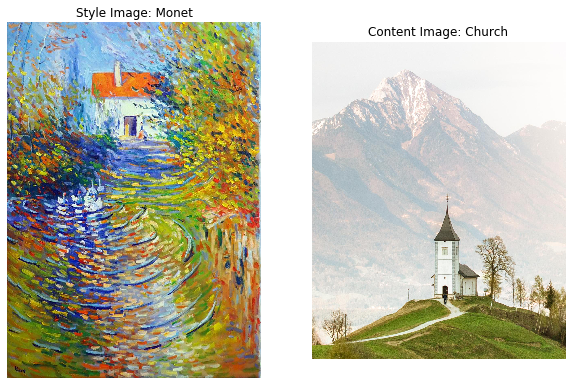

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(style_img)
ax[1].imshow(content_img)
ax[0].set_title('Style Image: {}'.format(style_name))
ax[1].set_title('Content Image: {}'.format(content_name))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

Now, I will initialize the loss and weights that will be passed into the VGG model at the start. The initial style weight and content weight determines which features from which image are more heavily considered to be included in the output image. 

The style loss is the contribution of each loss to the total loss from the Gram matrices and the content loss is the contribution of each loss to the total loss.

The total loss function that will be minimized is mathematically represented as follows:

$$L_{total} = \alpha L_{style} + \beta L_{content} $$

Where $\alpha$ is the weight factor for style reconstruction and $\beta$ is the weight factor for content reconstruction.

The implementation is as follows:

In [97]:
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']

loss_layers = style_layers + content_layers

style_loss = [GramMSELoss()] * len(style_layers)
content_loss = [nn.MSELoss()] * len(content_layers)

losses = style_loss + content_loss

if torch.cuda.is_available():
    losses = [loss.cuda() for loss in losses]

style_weight = 0.5
content_weight = 0.5
weights = [style_weight] * len(style_layers) + [content_weight] * len(content_layers)

style_targets = []
for target in vgg(style_torch, style_layers):
    target = GramMatrix()(target).detach()
    style_targets.append(target)
    
content_targets = []
for target in vgg(content_torch, content_layers):
    target = target.detach()
    content_targets.append(target)

targets = style_targets + content_targets

Now, I implement the training portion of the VGG network. I will use the L-BFGS optimization algorithm, as it is a proven strategy for image synthesis.

The training implementation follows a similar structure as for any convolutional neural network. The optimizer works to minimize the total loss function by updating the weights calculated through each epoch of the network.

In my implementation, I follow the general structure of implementing training with the L-BFGS optimization strategy, as explained in the PyTorch documentation. I print the loss at specified epochs in the training cycle to see how loss is minimized during the training run.

The implementation is as follows:

In [98]:
epochs = 500
epoch = [0]
optimizer = optim.LBFGS([opt_img])

print('Training with {} style weight and {} content weight'.format(style_weight, content_weight))
while epoch[0] <= epochs:
    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        loss = []
        for i in range(len(out)):
            loss.append(losses[i](out[i], targets[i]) * weights[i])
        total_loss = sum(loss)
        total_loss.backward()
        
        epoch[0] += 1
        
        if epoch[0] % 50 == 0:
            print('Epoch: {}'.format(epoch))
            print('Loss: {}'.format(total_loss.item()))
        
        return total_loss
    
    optimizer.step(closure)
print('Training complete.')

Training with 0.5 style weight and 0.5 content weight
Epoch: [50]
Loss: 253828832.0
Epoch: [100]
Loss: 83597920.0
Epoch: [150]
Loss: 50672844.0
Epoch: [200]
Loss: 36407388.0
Epoch: [250]
Loss: 28441300.0
Epoch: [300]
Loss: 22806426.0
Epoch: [350]
Loss: 18671860.0
Epoch: [400]
Loss: 15579221.0
Epoch: [450]
Loss: 13068534.0
Epoch: [500]
Loss: 10956967.0
Training complete.


With training complete, I convert the output tensor to an image and plot a figure with the style image, content image, and resulting output image.

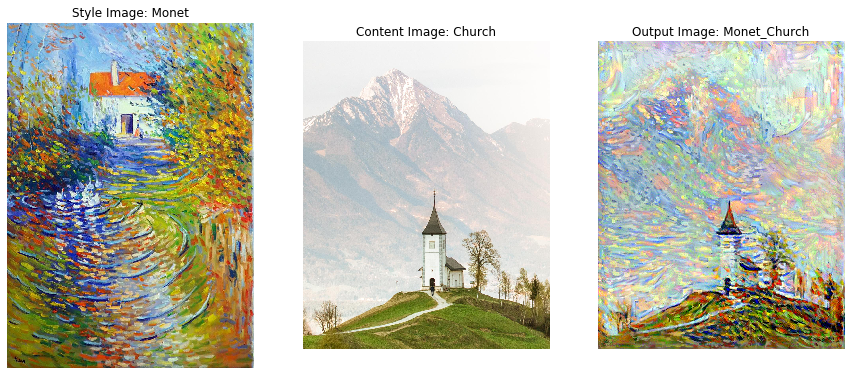

In [99]:
out_img = tensor_to_img(opt_img.data[0].cpu().squeeze())
out_name = style_name + '_' + content_name

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(style_img)
ax[1].imshow(content_img)
ax[2].imshow(out_img)
ax[0].set_title('Style Image: {}'.format(style_name))
ax[1].set_title('Content Image: {}'.format(content_name))
ax[2].set_title('Output Image: {}'.format(out_name))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

I now save the images to an output directory for record keeping purposes.

In [100]:
out_img.save(OUTPUT_DIR + out_name + '.jpg')

The results turned out better than expected! Now, I will show some other examples that I generated. The examples shown are ones of varying success.

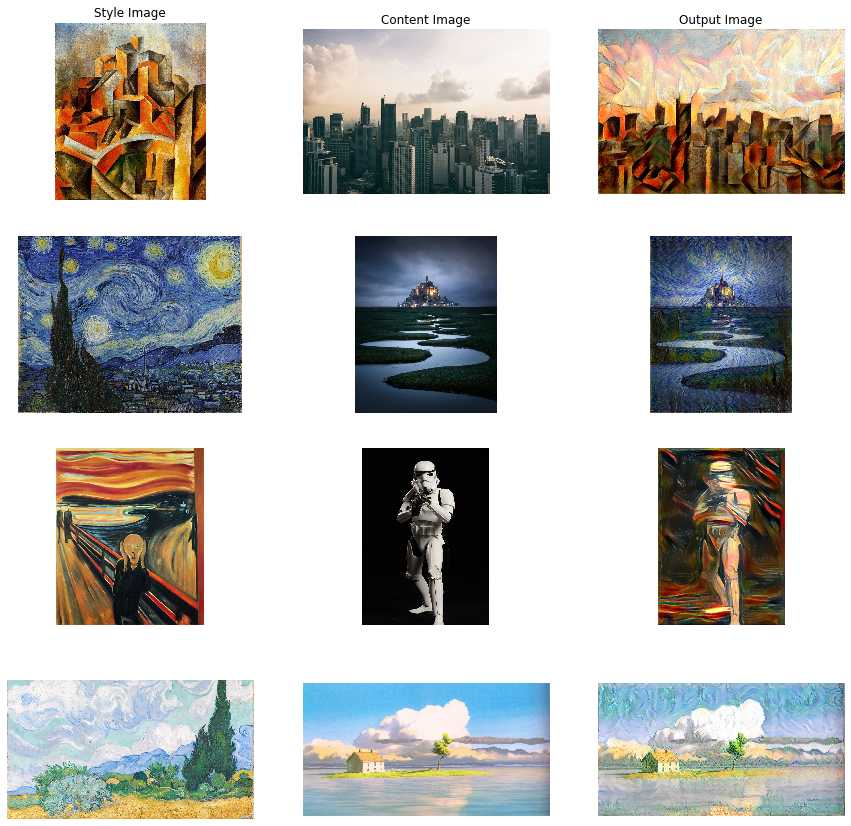

In [101]:
style_paths = ['picasso.jpg', 'vangogh.jpg', 'scream.jpg', 'vangogh2.jpg']
content_paths = ['city.jpg', 'castle.jpg', 'stormtrooper.jpg', 'spiritedaway.jpg']
output_paths = ['Picasso_City.jpg', 'Vangogh_Castle.jpg', 'Scream_Stormtrooper.jpg', 'Vangogh2_Spiritedaway.jpg']

fig, ax = plt.subplots(len(output_paths), 3, figsize=(15,15))
ax[0][0].set_title('Style Image')
ax[0][1].set_title('Content Image')
ax[0][2].set_title('Output Image')

for i in range(len(output_paths)):
    s = Image.open(STYLE_DIR + style_paths[i])
    c = Image.open(CONTENT_DIR + content_paths[i])
    o = Image.open(OUTPUT_DIR + output_paths[i])
    ax[i][0].imshow(s)
    ax[i][1].imshow(c)
    ax[i][2].imshow(o)
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')

plt.show()

As you can see, neural style transfer is being applied to the images provided. One thing I noticed was that the style and content images must be similar enough in lighting and color palette, or the style transfer could have less than desired results. Image sets 1 and 3 were more successful than image sets 2 and 4. For image 2, I believe the style that is captured is close, but the overall image looks as if arbitrary noise was added. This just could be due to the content image chosen. A similar thing happens with image 4. I believe for this one, the style captured is too small in scale, and again the resulting image looks as if noise was added.

Overall, the effectiveness of neural style transfer is determined by the style and content images and how closely similar they are. This can be by the best example, image 1. The contents within the style image closely match the contents within the content image, so the mapping is more visually pleasing.

The process of performing neural style transfer provided me with a lot of insight into what is going on in each layer of a convolutional neural network, as well as providing a look into how powerful and complex human visual systems are, and how we are able to distinguish between what is considered as art.